In [1]:
import torch 
import torch.nn as nn
import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn.metrics import accuracy_score

In [46]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [129]:
X_blob, y_blob = make_blobs(1000, 2, centers=4, cluster_std=1.5, random_state=42)
X_blob, y_blob = torch.from_numpy(X_blob).type(torch.float32), torch.from_numpy(y_blob).type(torch.LongTensor)

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=.2, random_state=42)
len(X_train), len(X_test)

(800, 200)

In [131]:
# X_train = torch.tensor(X_train, dtype=torch.float32, requires_grad=True)
# y_train = torch.tensor(y_train, dtype=torch.long, requires_grad=True)
# X_test = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
# y_test = torch.tensor(y_test, dtype=torch.long, requires_grad=True)


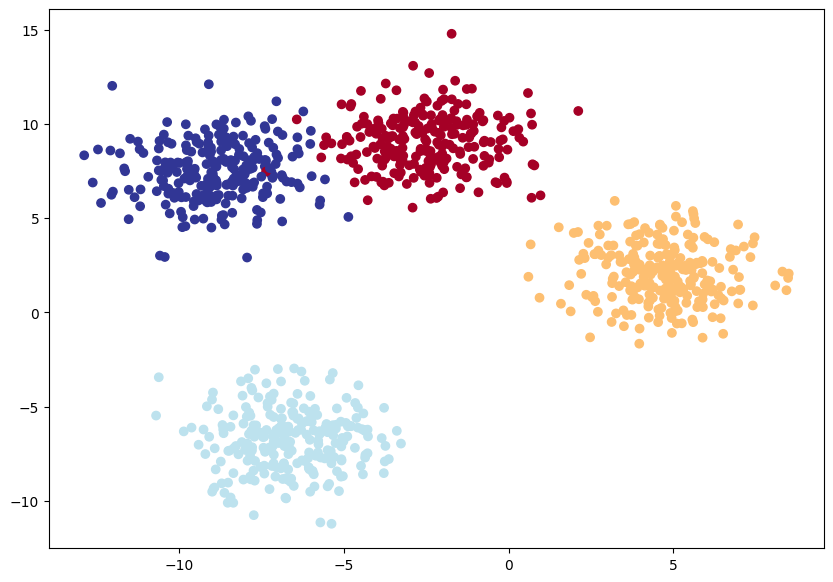

In [132]:
plt.figure(figsize=(10,7))
plt.scatter(x=X_blob[:, 0], y=X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

In [133]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [134]:
class MCCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8,8),
            nn.ReLU(),
            nn.Linear(8,4),
        )
    def forward(self, X):
        return self.seq(X)

In [135]:
torch.cuda.empty_cache()

In [136]:
model_4 = MCCModel().to(device)
model_4

MCCModel(
  (seq): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [137]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [138]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [139]:
model_4.eval()
with torch.inference_mode():
    pretrain_predict = torch.argmax(model_4(X_test.to(device)), dim=1)
    print(model_4(X_test.to(device))[:10])
print(pretrain_predict[:10])

tensor([[ 1.0371, -0.8304,  0.5584,  1.5113],
        [-0.1028, -0.7137, -0.4290, -0.7691],
        [-0.2028, -0.4125, -0.0846, -0.2559],
        [ 0.3326, -0.3861,  0.4821,  0.7750],
        [ 1.2190, -0.8531, -0.0045,  1.5242],
        [-0.0759, -0.8382, -0.5683, -0.9799],
        [-0.2356, -0.2875,  0.0337, -0.0839],
        [ 0.7391, -0.7746, -0.1796,  0.5548],
        [-0.1536, -0.5854, -0.2689, -0.5292],
        [ 0.9360, -0.8176, -0.1307,  0.9052]], device='cuda:0')
tensor([3, 0, 2, 3, 3, 0, 2, 0, 0, 0], device='cuda:0')


In [140]:
y_test[10:20]

tensor([0, 1, 0, 0, 0, 3, 3, 2, 3, 3], device='cuda:0')

In [142]:
epochs=101

for epoch in range(epochs):
    model_4.train()
    logits = model_4(X_train)
    loss = criterion(logits, y_train)
    pred = torch.argmax(logits, dim=1)
    acc = accuracy_score(y_train.cpu().detach(), pred.cpu().detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_test)
        test_loss = criterion(test_logits, y_test)
        test_pred= torch.argmax(test_logits, dim=1)
        test_acc = accuracy_score(y_test.cpu().detach(), test_pred.cpu().detach())

    if epoch %10 ==0:
        print(f"Epoch: {epoch} | Train Loss: {loss :.4f} | Test Loss: {test_loss :.4f} | Train Accuracy: {acc} | Test Accuracy: {test_acc}.")


Epoch: 0 | Train Loss: 1.4192 | Test Loss: 1.2683 | Train Accuracy: 0.46875 | Test Accuracy: 0.245.
Epoch: 10 | Train Loss: 0.6525 | Test Loss: 0.6185 | Train Accuracy: 0.73375 | Test Accuracy: 0.72.
Epoch: 20 | Train Loss: 0.3622 | Test Loss: 0.3659 | Train Accuracy: 0.89375 | Test Accuracy: 0.955.
Epoch: 30 | Train Loss: 0.2275 | Test Loss: 0.2251 | Train Accuracy: 0.9875 | Test Accuracy: 0.995.
Epoch: 40 | Train Loss: 0.1383 | Test Loss: 0.1327 | Train Accuracy: 0.985 | Test Accuracy: 0.995.
Epoch: 50 | Train Loss: 0.0944 | Test Loss: 0.0878 | Train Accuracy: 0.98375 | Test Accuracy: 0.995.
Epoch: 60 | Train Loss: 0.0731 | Test Loss: 0.0657 | Train Accuracy: 0.985 | Test Accuracy: 0.995.
Epoch: 70 | Train Loss: 0.0612 | Test Loss: 0.0533 | Train Accuracy: 0.985 | Test Accuracy: 0.995.
Epoch: 80 | Train Loss: 0.0537 | Test Loss: 0.0455 | Train Accuracy: 0.9875 | Test Accuracy: 0.995.
Epoch: 90 | Train Loss: 0.0487 | Test Loss: 0.0402 | Train Accuracy: 0.98875 | Test Accuracy: 0.995.


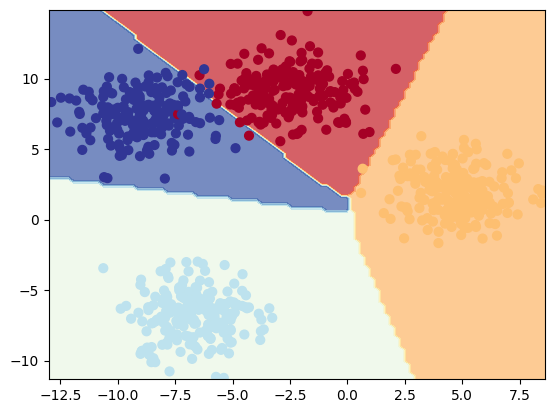

In [143]:
plot_decision_boundary(model_4, X_train.detach(), y_train.detach())